# TESS Background data

This notebook shows how to use `BackgroundCube` to get TESS Full Frame Images (FFI) scatter light component and Earth/Moon angles as pixel maps for every camera/ccd in the instrument.

This data could be used to train a machine learning model or used directly to correct the scatter light contribution in TESS cutouts. 

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# basic imports
import os
import numpy as np
from tess_backml import BackgroundCube
from tess_backml.utils import pooling_2d
import matplotlib.pyplot as plt

# increase animation frame limits
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 2**128

In [2]:
# define sector/camera/ccd
sector = 2
camera = 1
ccd = 1
binsize = 8

## Initialize
We initialize the object with a specific Sectopr/Camera/CCD, an image bin size, and a method for downsizing (default if 'binning')

In [3]:
bkg_data = BackgroundCube(
    sector=sector, camera=camera, ccd=ccd, img_bin=binsize, downsize="binning"
)
print(bkg_data)

TESS FFI Background object (Sector, Camera, CCD, N times): 2, 1, 1, 1235


## Get Flux Data
Compute the binned scatter light cube which does:
- Finds the darkest frame in the sector to build a star mask and a saturated pixel mask
- Adds a strap mask
- Pulls the FFI flux data from the cloud
- Downsize the image by doing median 8x8 (effective) binning, masking out stars, straps, and saturated pixels
    - If `rolling=True` downsizing is done with iterative rolling windows to get to the desired output shape, this will increase ~25% more the computing time, but will give more robust estimations around bright stars, saturated pixes, and straps.
- The resulting scatter light cube has shape [nt, 256, 256]

Note: this is the most time consuming step, most of the computing time is spend in I/O (~50-60% of each iteration). This can be speed up if we run this notebook in TIKE and take advantage of AWS, if that's the case, a typical Sector/Camera/CCD should take ~30-40 minutes, depending of load. In a local machine, it can take up to 1h depending on internet connection.

INFO:tess_backml:Computing sector darkest frames...
INFO:tess_backml:Computing star mask...


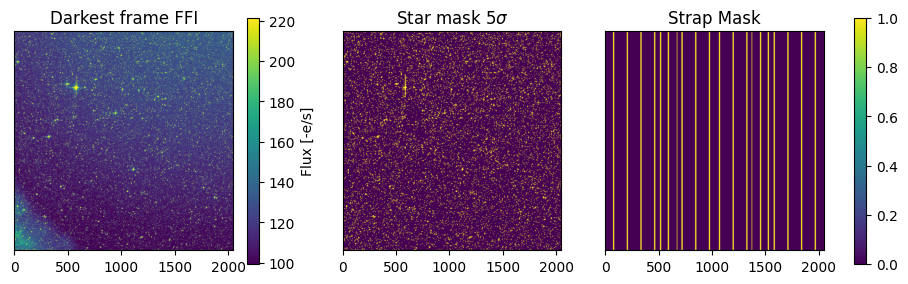

INFO:tess_backml:Getting FFI flux cube...
INFO:tess_backml:Computing average static scene from darkes frames...


Iterating frames: 100%|██████████████████████████████████████████████████████████████████| 1245/1245 [1:25:30<00:00,  4.12s/it]


In [4]:
bkg_data.get_scatter_light_cube(frames=None, mask_straps=True, plot=True, rolling=True)

We can animate the scatter light cube for visualization

In [6]:
bkg_data.animate_data(data="sl", save=False, step=10);

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Compute Angle Maps
Now we compute the Earth/Moon vector maps:
- We pull the Earth/Moon distance, azimuth, and elevation angles from the engineering files. This values a w.r.t. each camera's boresight and changes for each frame in the sector.
Using trigonometric rules, we compute these values for each pixel in the downsized grid [nt, 128, 128].
- If `ang_size == True` then the Earth/Moon distances are changed to angular size.

In [7]:
bkg_data.get_vector_maps(ang_size=True)

INFO:root:Retrieving TESSVector from: https://heasarc.gsfc.nasa.gov/docs/tess/data/TESSVectors/Vectors/FFI_Cadence/TessVectors_S002_C1_FFI.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 1245/1245 [00:02<00:00, 465.24it/s]


We can inspect these maps for a single frame

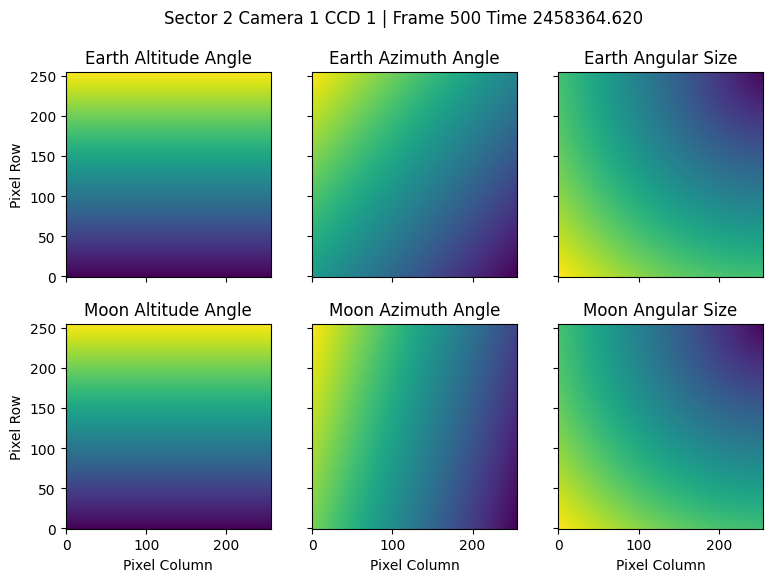

In [8]:
tdx = 500

fig, ax = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=True)

fig.suptitle(
    f"Sector {sector} Camera {camera} CCD {ccd} | "
    f"Frame {tdx} Time {bkg_data.time[tdx]:.3f}"
)
ax[0, 0].imshow(bkg_data.earth_maps["alt"][tdx], origin="lower")
ax[0, 1].imshow(bkg_data.earth_maps["az"][tdx], origin="lower")
ax[0, 2].imshow(bkg_data.earth_maps["dist"][tdx], origin="lower")

ax[0, 0].set_title("Earth Altitude Angle")
ax[0, 1].set_title("Earth Azimuth Angle")
ax[0, 2].set_title("Earth Angular Size")

ax[1, 0].imshow(bkg_data.moon_maps["alt"][tdx], origin="lower")
ax[1, 1].imshow(bkg_data.moon_maps["az"][tdx], origin="lower")
ax[1, 2].imshow(bkg_data.moon_maps["dist"][tdx], origin="lower")

ax[1, 0].set_title("Moon Altitude Angle")
ax[1, 1].set_title("Moon Azimuth Angle")
ax[1, 2].set_title("Moon Angular Size")

ax[0, 0].set_ylabel("Pixel Row")
ax[1, 0].set_ylabel("Pixel Row")
ax[1, 0].set_xlabel("Pixel Column")
ax[1, 1].set_xlabel("Pixel Column")
ax[1, 2].set_xlabel("Pixel Column")

plt.show()

In [9]:
bkg_data.scatter_cube.shape, bkg_data.earth_maps["dist"].shape

((1235, 256, 256), (1235, 256, 256))

## Time binning

We can do time binning to reduce size of the cubes and save memory/storage. The function `bkg_data.bin_time_axis()` takes the parameter `bin_size` as the size of the bin in hours.
This creates new attributes (e.g. `bkg_data.time_bin` and `bkg_data.scatter_cube_bin`)

In [11]:
bkg_data.bin_time_axis(bin_size=2.0)
bkg_data.time_bin.shape, bkg_data.scatter_cube_bin.shape, bkg_data.earth_maps_bin["dist"].shape

((312,), (312, 256, 256), (312, 256, 256))

## Save Data
The computed scatter light, angle maps, and times values can be saved to disk as a `npz` file for future use. This will save the cubes/vectors with all times, no binning.

In [12]:
# save data to disk
fname = f"./data/ffi_cubes_bin{bkg_data.img_bin}_sector{sector:03}_{camera}-{ccd}_light.npz"
print(fname)
bkg_data.save_data_npz(out_file=fname, save_maps=True)

./data/ffi_cubes_bin8_sector002_1-1_light.npz


In [13]:
data = np.load(fname, )
data.items()

ItemsView(NpzFile './data/ffi_cubes_bin8_sector002_1-1_light.npz' with keys: scatter_cube, time, cadenceno, earth_alt, earth_az...)

In [14]:
data["scatter_cube"].shape, data["earth_alt_map"].shape

((1235, 256, 256), (1235, 256, 256))

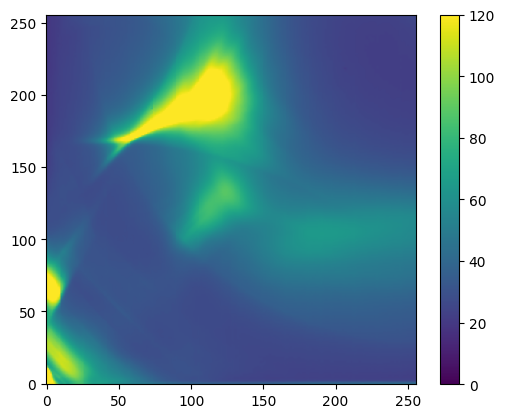

In [15]:
bar = plt.imshow(data["scatter_cube"][1180], origin="lower", vmin=0, vmax=120,)
plt.colorbar(bar)
plt.show()

Or save only the scatter light cube in its binned version to `FITS` file.

In [25]:
fname = f"./data/ffi_cubes_bin{bkg_data.img_bin}_sector{sector:03}_{camera}-{ccd}_light.fits"
print(fname)
_ = bkg_data.save_to_fits(out_file=fname, binned=True)

./data/ffi_cubes_bin8_sector002_1-1_light.fits


In [26]:
from astropy.io import fits

In [27]:
hdul = fits.open(fname)
hdul.info()

Filename: ./data/ffi_cubes_bin8_sector002_1-1_light.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  SCATTER LIGHT CUBE    1 ImageHDU        10   (2, 312, 256, 256)   float64   
  2  PIXEL COUNTS    1 ImageHDU         8   (256, 256)   int64   
  3  TIME          1 BinTableHDU     13   312R x 1C   [D]   
